In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import joblib
import subprocess
import polars as pl
import io
import glob
import statsmodels.stats.proportion

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference
from src.IDs import *

In [4]:
ceph_good_samples = "NA12878,NA12879,NA12881,NA12882,NA12886,NA12892,200084,200085,200102,200104".split(',')

In [5]:
output_path = Path("/lustre/scratch122/tol/projects/sperm/results/CEPH_20241119/")

In [6]:
%%time
reads_df = \
    pl.scan_parquet(
        glob.glob(str(output_path / "read_analysis/*/*/reads/*/classified.parquet"))
    ) 


CPU times: user 6.69 ms, sys: 96.4 ms, total: 103 ms
Wall time: 415 ms


In [7]:
%%time
candidates_df = (reads_df
    # .select(
    #     'read_name',
    #     'chrom',
    #     'sample_id',
    #     "class",
    #     'high_quality_classification'  
    # )
    .filter(pl.col("high_quality_classification"))
    .filter(pl.col("sample_id").is_in(ceph_good_samples))
    .collect(streaming=True)
)

CPU times: user 2.47 s, sys: 1.34 s, total: 3.81 s
Wall time: 2.31 s


In [22]:
sample_id = "NA12890"
sample_set = sample_id
flow_cell = "m54329U_230413_155849"
chrom = "chr1"

snps_df = pl.read_parquet(
    output_path / f"read_analysis/{sample_set}/{sample_id}/{flow_cell}/{chrom}/annotated_0.95_high_confidence_snps.parquet"
)

subset_snps_df = (snps_df
    .join(candidates_df, on=["read_name"])
)

In [23]:
ps = diagnostics.binom_test_array(
    subset_snps_df["hap1_certainty_0.95_coverage"],
    subset_snps_df["hap2_certainty_0.95_coverage"],
)

In [24]:
rel_df = (subset_snps_df
    .with_columns(
        pl.Series("binom_p", ps),
    )
    .group_by("read_name")
    .agg(
        pl.col("binom_p").min(),
    )
)

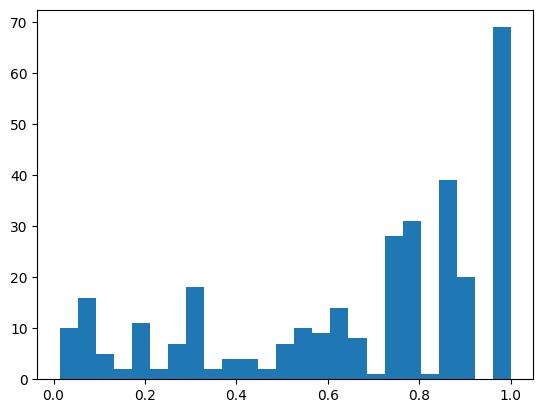

In [26]:
plt.hist(
    #np.log10(ps),
    #ps,
    #np.log10(rel_df["binom_p"]),
    bins=25,
);

In [1]:
snps_df

NameError: name 'snps_df' is not defined

In [8]:
call_stats_df = (candidates_df    
    .pivot(
        values=["class"],
        index=["sample_id"],
        on=["class"],
        aggregate_function='len'
    )
    .sort(by="sample_id")
    .select("sample_id", "CO", "GC", "ambiguous", "CNCO")
    .fill_null(0)
)

with pl.Config(tbl_rows=40):
    display(call_stats_df)

sample_id,CO,GC,ambiguous,CNCO
str,u32,u32,u32,u32
"""200084""",0,103,33,6
"""200085""",2,77,13,5
"""200102""",3,93,61,7
"""200104""",3,62,36,6
"""NA12878""",5,143,36,7
"""NA12879""",0,68,23,8
"""NA12881""",5,76,19,5
"""NA12882""",6,97,22,4
"""NA12886""",0,54,14,4


In [28]:
(candidates_df 
    .filter(basic_filtering)
    .filter(extra_filtering)  
    .filter(pl.col("chrom") == "chr1")
    .filter(pl.col("sample_id") == "200082")
    .filter(pl.col("class") == "CO")
)

read_name,read_length,n_transitions,idx_transitions,snp_positions_on_read,class,total_mismatches,total_common_insertions,num_common_insertions,num_common_deletions,total_clipping,num_clipping,min_coverage_between_transitions_hap1,min_coverage_between_transitions_hap2,mapq1,mapq2,is_forward1,is_forward2,has_common_transition,high_quality_classification,chrom,sample_id,sample_set
str,i64,i64,list[i64],list[i64],str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,bool,bool,bool,bool,str,str,str
"""m84046_230704_220127_s2/833656…",18953,1,[1],"[571, 6351, … 17806]","""CO""",18,48,46,63,0,0,10,17,60,60,false,false,false,true,"""chr1""","""200082""","""200082"""
"""m84046_230708_193430_s1/115215…",26234,1,[38],"[501, 1046, … 23877]","""CO""",3,16,16,31,0,0,23,7,60,60,false,false,false,true,"""chr1""","""200082""","""200082"""
"""m84046_230704_213021_s1/102829…",25966,1,[1],"[1346, 13123, … 23571]","""CO""",2,9,9,36,0,0,3,12,60,60,false,false,false,true,"""chr1""","""200082""","""200082"""
"""m84046_230711_223630_s1/181207…",26079,1,[1],"[12920, 13104, … 21372]","""CO""",43,36,13,11,0,0,3,22,60,60,false,false,false,true,"""chr1""","""200082""","""200082"""
"""m84046_230701_010431_s2/154735…",23048,1,[1],"[4136, 6713, … 22171]","""CO""",5,8,8,11,0,0,21,6,60,60,true,true,false,true,"""chr1""","""200082""","""200082"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""m84046_230708_193430_s1/207619…",17112,1,[1],"[1054, 7607, … 16043]","""CO""",4,45,37,29,0,0,25,3,60,60,false,false,false,true,"""chr1""","""200082""","""200082"""
"""m84046_230708_193430_s1/748451…",23087,1,[1],"[1224, 5113, … 21919]","""CO""",1,22,21,15,0,0,16,6,60,60,true,true,false,true,"""chr1""","""200082""","""200082"""
"""m84046_230701_010431_s2/755009…",16867,1,[2],"[1098, 1221, … 7883]","""CO""",6,1,1,21,0,0,23,12,60,60,true,true,false,true,"""chr1""","""200082""","""200082"""


In [39]:
(
    pl.read_parquet(
        glob.glob(str(output_path / "read_analysis/200086/*/reads/chr1/classified.parquet"))
    )
    .filter(pl.col("read_name").str.starts_with("m84046_230703_212031_s1"))
    .filter(basic_filtering)
    .filter(extra_filtering)
    .filter(pl.col("class") == "CO")
)

read_name,read_length,n_transitions,idx_transitions,snp_positions_on_read,class,total_mismatches,total_common_insertions,num_common_insertions,num_common_deletions,total_clipping,num_clipping,min_coverage_between_transitions_hap1,min_coverage_between_transitions_hap2,mapq1,mapq2,is_forward1,is_forward2,has_common_transition,high_quality_classification,chrom,sample_id,sample_set
str,i64,i64,list[i64],list[i64],str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,bool,bool,bool,bool,str,str,str
"""m84046_230703_212031_s1/157343…",31099,1,[18],"[590, 781, … 28835]","""CO""",6,33,31,31,0,0,14,12,60,60,false,false,false,true,"""chr1""","""200086""","""200086"""
"""m84046_230703_212031_s1/628544…",27417,1,[5],"[2563, 3140, … 26934]","""CO""",12,60,27,54,2,1,9,11,60,60,false,false,false,true,"""chr1""","""200086""","""200086"""
"""m84046_230703_212031_s1/447653…",27370,1,[17],"[922, 2302, … 26965]","""CO""",15,43,39,60,0,0,31,11,60,60,true,true,false,true,"""chr1""","""200086""","""200086"""
"""m84046_230703_212031_s1/287707…",14951,1,[1],"[2170, 3016, … 14679]","""CO""",21,24,22,54,0,0,13,11,60,60,true,true,false,true,"""chr1""","""200086""","""200086"""
"""m84046_230703_212031_s1/241370…",16643,1,[3],"[1930, 5760, … 14666]","""CO""",6,35,34,29,8,1,16,7,60,60,true,true,false,true,"""chr1""","""200086""","""200086"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""m84046_230703_212031_s1/168100…",18624,1,[1],"[4520, 6665, … 17742]","""CO""",99,38,11,16,0,0,24,4,60,60,false,false,false,true,"""chr1""","""200086""","""200086"""
"""m84046_230703_212031_s1/215613…",24456,1,[1],"[3033, 3248, … 14835]","""CO""",24,35,33,93,9,1,18,8,60,60,true,true,false,true,"""chr1""","""200086""","""200086"""
"""m84046_230703_212031_s1/183502…",26273,1,[1],"[1795, 5463, … 23537]","""CO""",34,120,114,81,0,0,15,4,60,60,false,false,false,true,"""chr1""","""200086""","""200086"""


In [13]:
condition = (
    (pl.col("mapq1") >= 60) & \
    (pl.col("mapq2") >= 60) & \
    (pl.col("is_forward1") == pl.col("is_forward2")) & \
    (pl.col("total_mismatches") <= 100) & \
    (pl.col("total_clipping") <= 10)
)

In [30]:
(snps_df
    .filter(condition)
    .filter("is_snp")
)

ComputeError: cannot compare string with numeric type (i32)

In [34]:
df1 = (snps_df
    .filter(condition)
    .filter("is_snp")
    .filter(pl.col("op1") == 7)
    .group_by("ref1_start")
    .len().rename({"len": "allele_coverage_hap1"})
)

df2 = (snps_df
    .filter(condition)
    .filter("is_snp")
    .filter(pl.col("op2") == 7)
    .group_by("ref2_start")
    .len().rename({"len": "allele_coverage_hap2"})
)



In [35]:
(snps_df
    .join(
        df1,
        on=["ref1_start"],
        how="left",
    )
    .join(
        df2,
        on=["ref2_start"],
        how="left",
    )
    .with_columns(
        pl.col("allele_coverage_hap1").fill_null(0),
        pl.col("allele_coverage_hap2").fill_null(0),
    )
)

start,end,length,op1,op2,ref1_start,ref1_end,ref1_gap,ref2_start,ref2_end,ref2_gap,cigar_ptr1,cigar_ptr2,read_name,read_length1,read_length2,is_forward1,mapq1,ref1_name,qual_start1,refseq_start1,is_forward2,mapq2,ref2_name,qual_start2,refseq_start2,total_mismatches,total_common_insertions,num_common_insertions,num_common_deletions,total_clipping,num_clipping,is_snp,is_two_sided_mismatch,is_interesting_event,is_flanked_event,fits1_more,trf_repeat_length_hap1,trf_n_copies_hap1,trf_repeat_length_hap2,trf_n_copies_hap2,sdust_repeat_length_hap1,sdust_repeat_length_hap2,is_high_conf_event,is_high_conf_snp,is_mid_conf_event,is_mid_conf_snp,hap1_certainty_0.95_coverage,hap2_certainty_0.95_coverage,allele_coverage_hap1,allele_coverage_hap2,hap_certainty_0.95_coverage_balance_p,allele_coverage_balance_p,is_high_quality_event,is_high_quality_snp,is_mid_quality_event,is_mid_quality_snp,allele_coverage_hap1_right,allele_coverage_hap2_right
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i32,i32,bool,i32,str,u8,str,bool,i32,str,u8,str,i64,i64,u32,u32,i64,u32,bool,bool,bool,bool,i32,i64,f64,i64,f64,i32,i32,bool,bool,bool,bool,i64,i64,u32,u32,f64,f64,bool,bool,bool,bool,u32,u32
10621,10622,1,8,7,194992349,194992350,1,196366579,196366580,1,15,16,"""m84046_230711_223630_s1/209716…",21321,21321,true,60,"""chr1_RagTag""",40,"""A""",true,60,"""chr1_RagTag""",40,"""C""",0,6,6,10,0,0,true,false,true,true,0,0,0.0,0,0.0,0,0,true,true,true,true,12,24,8,8,0.065245,1.0,true,true,true,true,10,8
13280,13281,1,8,7,194995010,194995011,1,196369240,196369241,1,21,20,"""m84046_230711_223630_s1/209716…",21321,21321,true,60,"""chr1_RagTag""",40,"""A""",true,60,"""chr1_RagTag""",40,"""T""",0,6,6,10,0,0,true,false,true,true,0,0,0.0,0,0.0,0,0,true,true,true,true,12,22,8,8,0.121449,1.0,true,true,true,true,8,8
19109,19110,1,8,7,195000841,195000842,1,196375071,196375072,1,31,28,"""m84046_230711_223630_s1/209716…",21321,21321,true,60,"""chr1_RagTag""",22,"""A""",true,60,"""chr1_RagTag""",22,"""G""",0,6,6,10,0,0,true,false,true,true,0,0,0.0,0,0.0,0,0,false,false,false,false,8,28,8,8,0.001193,1.0,false,false,false,false,8,11
19365,19366,1,8,7,195001097,195001098,1,196375327,196375328,1,33,28,"""m84046_230711_223630_s1/209716…",21321,21321,true,60,"""chr1_RagTag""",40,"""T""",true,60,"""chr1_RagTag""",40,"""A""",0,6,6,10,0,0,true,false,true,true,0,0,0.0,0,0.0,0,0,true,true,true,true,8,28,8,8,0.001193,1.0,true,true,true,true,8,11
1529,1530,1,8,8,175898208,175898209,1,177352863,177352864,1,17,17,"""m84046_230711_223630_s1/833644…",22467,22467,true,60,"""chr1_RagTag""",10,"""A""",true,60,"""chr1_RagTag""",10,"""A""",9,30,29,70,0,0,false,true,true,true,0,0,0.0,0,0.0,0,0,false,false,false,false,35,1,null,null,1.0768e-9,NaN,false,false,false,false,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
12165,12166,1,7,8,107545627,107545628,1,107834861,107834862,1,6,37,"""m84046_230711_223630_s1/115934…",23378,23378,false,60,"""chr1_RagTag""",40,"""T""",false,60,"""chr1_RagTag""",40,"""G""",3,1,1,6,0,0,true,false,true,true,1,0,0.0,0,0.0,0,0,true,true,true,true,44,3,26,26,2.4647e-10,1.0,false,false,false,false,26,null
14611,14612,1,8,8,107548074,107548075,1,107837308,107837309,1,9,41,"""m84046_230711_223630_s1/115934…",23378,23378,false,60,"""chr1_RagTag""",17,"""T""",false,60,"""chr1_RagTag""",17,"""T""",3,1,1,6,0,0,false,true,true,true,0,0,0.0,0,0.0,0,0,false,false,false,false,42,4,null,null,5.1002e-9,NaN,false,false,false,false,null,null
14749,14750,1,8,7,107548212,107548213,1,107837446,107837447,1,11,42,"""m84046_230711_223630_s1/115934…",23378,23378,false,60,"""chr1_RagTag""",40,"""T""",false,60,"""chr1_RagTag""",40,"""C""",3,1,1,6,0,0,true,false,true,true,0,0,0.0,0,0.0,0,0,true,true,true,true,41,4,10,10,9.3349e-9,1.0,false,false,false,false,15,10


In [48]:
covdf = pl.read_csv(
    "/lustre/scratch122/tol/projects/sperm/results/CEPH_20241119/read_analysis/200082/genome_coverage/chr1/haplotype_2/hifiasm_haplotagged_0.95.coverage.bedgraph",
    separator="\t",
    has_header=False,
    new_columns=["chrom", "start_pos_0based", "end_pos_0based", "coverage"],
)

In [56]:
ref_start_column_name = "ref2_start"

(snps_df
    .filter("is_interesting_event")
    .select([ref_start_column_name])
    .unique([ref_start_column_name])
    .sort(by=ref_start_column_name)
    .set_sorted(ref_start_column_name)
    .join_asof(
        (covdf                    
            .select(["start_pos_0based", "end_pos_0based", "coverage"])
            .sort("start_pos_0based")
            .set_sorted("start_pos_0based")
        ),
        left_on=ref_start_column_name,
        right_on="start_pos_0based",
        strategy="backward",
    )
    .filter(pl.col("ref2_start") <= 38080298)
    .tail()
)

ref2_start,start_pos_0based,end_pos_0based,coverage
i64,i64,i64,i64
38079554,38079529,38079592,13
38079646,38079632,38079749,15
38079783,38079766,38079799,15
38080049,38080049,38080094,16
38080298,38080135,38080325,15


In [53]:
snps_df = pl.read_parquet(
    output_path / f"read_analysis/{sample_set}/{sample_id}/{flow_cell}/{chrom}/high_confidence_snps.parquet"
)

hap_and_certainty_to_bedgraph = {}
hap_and_certainty_to_bedgraph[(1, "0.95")] = "/lustre/scratch122/tol/projects/sperm/results/CEPH_20241119/read_analysis/200082/genome_coverage/chr1/haplotype_1/hifiasm_haplotagged_0.95.coverage.bedgraph"
hap_and_certainty_to_bedgraph[(2, "0.95")] = "/lustre/scratch122/tol/projects/sperm/results/CEPH_20241119/read_analysis/200082/genome_coverage/chr1/haplotype_2/hifiasm_haplotagged_0.95.coverage.bedgraph"
annotated_snps_df = diagnostics.add_phasing_coverage_annotation(
    snps_df,
    hap_and_certainty_to_bedgraph,
    pl.col("is_interesting_event"),
)

In [59]:
annotated_snps_df.filter(pl.col("ref2_start") == 38080298)

start,end,length,op1,op2,ref1_start,ref1_end,ref1_gap,ref2_start,ref2_end,ref2_gap,cigar_ptr1,cigar_ptr2,read_name,read_length1,read_length2,is_forward1,mapq1,ref1_name,qual_start1,refseq_start1,is_forward2,mapq2,ref2_name,qual_start2,refseq_start2,total_mismatches,total_common_insertions,num_common_insertions,num_common_deletions,total_clipping,num_clipping,is_snp,is_two_sided_mismatch,is_interesting_event,is_flanked_event,fits1_more,trf_repeat_length_hap1,trf_n_copies_hap1,trf_repeat_length_hap2,trf_n_copies_hap2,sdust_repeat_length_hap1,sdust_repeat_length_hap2,is_high_conf_event,is_high_conf_snp,is_mid_conf_event,is_mid_conf_snp,hap1_certainty_0.95_coverage,hap2_certainty_0.95_coverage
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i32,i32,bool,i32,str,u8,str,bool,i32,str,u8,str,i64,i64,u32,u32,i64,u32,bool,bool,bool,bool,i32,i64,f64,i64,f64,i32,i32,bool,bool,bool,bool,i64,i64
16227,16228,1,8,7,38164979,38164980,1,38080298,38080299,1,143,112,"""m84046_230711_223630_s1/931972…",21942,21942,false,60,"""chr1_RagTag""",40,"""G""",false,60,"""chr1_RagTag""",40,"""C""",3,14,13,44,0,0,true,false,true,true,0,0,0.0,0,0.0,0,0,true,true,true,true,7,15
16289,16290,1,8,7,38164979,38164980,1,38080298,38080299,1,377,346,"""m84046_230711_223630_s1/291677…",17983,17983,true,60,"""chr1_RagTag""",40,"""G""",true,60,"""chr1_RagTag""",40,"""C""",42,54,50,103,0,0,true,false,true,true,0,0,0.0,0,0.0,0,0,true,true,true,true,7,15
2527,2528,1,7,8,38164979,38164980,1,38080298,38080299,1,16,23,"""m84046_230711_223630_s1/246289…",19163,19163,true,60,"""chr1_RagTag""",40,"""G""",true,60,"""chr1_RagTag""",40,"""C""",7,41,9,25,0,0,true,false,true,true,1,0,0.0,0,0.0,0,0,true,true,true,true,7,15
19599,19600,1,7,8,38164979,38164980,1,38080298,38080299,1,317,338,"""m84046_230711_223630_s1/116003…",21830,21830,true,60,"""chr1_RagTag""",17,"""G""",true,60,"""chr1_RagTag""",17,"""C""",24,29,27,119,16,1,true,false,true,true,1,0,0.0,0,0.0,0,0,false,false,false,false,7,15
4338,4339,1,7,8,38164979,38164980,1,38080298,38080299,1,20,39,"""m84046_230711_223630_s1/685565…",23269,23269,true,60,"""chr1_RagTag""",40,"""G""",true,60,"""chr1_RagTag""",40,"""C""",8,49,18,29,0,0,true,false,true,true,1,0,0.0,0,0.0,0,0,true,true,true,true,7,15
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
685,686,1,8,7,38164979,38164980,1,38080298,38080299,1,11,8,"""m84046_230711_223630_s1/200213…",26391,26391,true,60,"""chr1_RagTag""",40,"""G""",true,60,"""chr1_RagTag""",40,"""C""",15,51,50,72,4,1,true,false,true,true,0,0,0.0,0,0.0,0,0,true,true,true,true,7,15
15120,15121,1,7,8,38164979,38164980,1,38080298,38080299,1,22,43,"""m84046_230711_223630_s1/728142…",18784,18784,true,60,"""chr1_RagTag""",40,"""G""",true,60,"""chr1_RagTag""",40,"""C""",6,8,4,5,0,0,true,false,true,true,1,0,0.0,0,0.0,0,0,true,true,true,true,7,15
15721,15722,1,8,7,38164979,38164980,1,38080298,38080299,1,43,6,"""m84046_230711_223630_s1/218040…",17310,17310,false,60,"""chr1_RagTag""",40,"""G""",false,60,"""chr1_RagTag""",40,"""C""",1,1,1,4,0,0,true,false,true,true,0,0,0.0,0,0.0,0,0,true,true,true,true,7,15


In [60]:
flow_cell

'm84046_230711_223630_s1'

In [64]:
pl.scan_parquet(
    glob.glob(
        "/lustre/scratch122/tol/projects/sperm/results/CEPH_20241119/read_analysis/NA12879/NA12879/*/chr22/annotated_0.95_high_confidence_snps.parquet"
    )
).count().collect()

start,end,length,op1,op2,ref1_start,ref1_end,ref1_gap,ref2_start,ref2_end,ref2_gap,cigar_ptr1,cigar_ptr2,read_name,read_length1,read_length2,is_forward1,mapq1,ref1_name,qual_start1,refseq_start1,is_forward2,mapq2,ref2_name,qual_start2,refseq_start2,total_mismatches,total_common_insertions,num_common_insertions,num_common_deletions,total_clipping,num_clipping,is_snp,is_two_sided_mismatch,is_interesting_event,is_flanked_event,fits1_more,trf_repeat_length_hap1,trf_n_copies_hap1,trf_repeat_length_hap2,trf_n_copies_hap2,sdust_repeat_length_hap1,sdust_repeat_length_hap2,is_high_conf_event,is_high_conf_snp,is_mid_conf_event,is_mid_conf_snp,hap1_certainty_0.95_coverage,hap2_certainty_0.95_coverage,allele_coverage_hap1,allele_coverage_hap2,hap_certainty_0.95_coverage_balance_p,allele_coverage_balance_p,is_high_quality_event,is_high_quality_snp,is_mid_quality_event,is_mid_quality_snp
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,2131829,985040,944510,2131829,2131829,1690956,1692332,1638648,1641599


In [7]:
sample_set = "200080"
sample_id = "200080"
flow_cell = "m84046_230708_193430_s1"
chrom = "chr5"

snps_df = pl.read_parquet(
    output_path / f"read_analysis/{sample_set}/{sample_id}/{flow_cell}/{chrom}/high_confidence_snps.parquet"
)

In [12]:
hap_stats_df = diagnostics.snps_to_read_stats(
    snps_df,
    pl.col("is_high_conf_snp"),
    "frac_fits1_more_snps_high_conf",    
)

read_to_frac = dict(hap_stats_df.select(pl.col("read_name"), pl.col("frac_fits1_more_snps_high_conf").fill_null(0.5)).to_numpy())

In [40]:
import pysam

input_bam_hap1_filename = str(
    output_path / f"alignments/{sample_set}/{sample_id}/{flow_cell}/T2T_scaffolds/haplotype_1" \
            / "minimap2.sorted.primary_alignments.bam")

bam = pysam.AlignmentFile(input_bam_hap1_filename)
for read in tqdm.tqdm(bam.fetch(contig=chrom+"_RagTag", start=86117451, end=86117451+1)):
    print(read.query_name, read.query_name  in read_to_frac.keys())


9it [00:00, 5407.35it/s]

m84046_230708_193430_s1/13046896/ccs True
m84046_230708_193430_s1/158731204/ccs True
m84046_230708_193430_s1/110760744/ccs True
m84046_230708_193430_s1/101650789/ccs True
m84046_230708_193430_s1/250874349/ccs False
m84046_230708_193430_s1/231150490/ccs True
m84046_230708_193430_s1/166138046/ccs True
m84046_230708_193430_s1/132122146/ccs False
m84046_230708_193430_s1/186323290/ccs False


In [41]:
missing_read = "m84046_230708_193430_s1/250874349/ccs"

In [42]:
snps_df.filter(pl.col("read_name") == missing_read)

start,end,length,op1,op2,ref1_start,ref1_end,ref1_gap,ref2_start,ref2_end,ref2_gap,cigar_ptr1,cigar_ptr2,read_name,read_length1,read_length2,is_forward1,mapq1,ref1_name,qual_start1,refseq_start1,is_forward2,mapq2,ref2_name,qual_start2,refseq_start2,total_mismatches,total_common_insertions,num_common_insertions,num_common_deletions,total_clipping,num_clipping,is_snp,is_two_sided_mismatch,is_interesting_event,is_flanked_event,fits1_more,trf_repeat_length_hap1,trf_n_copies_hap1,trf_repeat_length_hap2,trf_n_copies_hap2,sdust_repeat_length_hap1,sdust_repeat_length_hap2,is_high_conf_event,is_high_conf_snp,is_mid_conf_event,is_mid_conf_snp
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i32,i32,bool,i32,str,u8,str,bool,i32,str,u8,str,i64,i64,u32,u32,i64,u32,bool,bool,bool,bool,i32,i64,f64,i64,f64,i32,i32,bool,bool,bool,bool
6019,6020,1,8,7,86117451,86117452,1,89431916,89431917,1,21,18,"""m84046_230708_193430_s1/250874…",24380,24380,false,60,"""chr5_RagTag""",17,"""T""",false,60,"""chr5_RagTag""",17,"""C""",2,9,9,20,0,0,true,false,true,true,0,0,0.0,0,0.0,0,0,false,false,false,false
7638,7639,1,8,8,86119070,86119071,1,89433535,89433536,1,27,23,"""m84046_230708_193430_s1/250874…",24380,24380,false,60,"""chr5_RagTag""",3,"""A""",false,60,"""chr5_RagTag""",3,"""A""",2,9,9,20,0,0,false,true,true,true,0,0,0.0,0,0.0,0,0,false,false,false,false
18201,18202,1,8,8,86129641,86129642,1,89444106,89444107,1,63,57,"""m84046_230708_193430_s1/250874…",24380,24380,false,60,"""chr5_RagTag""",10,"""T""",false,60,"""chr5_RagTag""",10,"""T""",2,9,9,20,0,0,false,true,true,true,0,0,0.0,0,0.0,0,0,false,false,false,false


In [43]:
hap_stats_df.filter(pl.col("read_name") == missing_read)

read_name,frac_fits1_more_snps_high_conf
str,f64


In [37]:
read_to_frac[missing_read]

0.75

In [39]:
missing_read not in read_to_frac.keys()

False

In [88]:
ceph_sample_ids = [
    "NA12877",
    "NA12878",
    "NA12879",
    "NA12881",
    "NA12882",
    "NA12885",
    "NA12886",
   # "NA12887", -- not there yet?
    "NA12889",
    "NA12890",
    "NA12891",
    "NA12892",
    "200080", 
    "200082",
    "200084",
    "200085",
    "200086",
    "200087",
    "200100", 
    "200101",
    "200102",
    "200104",
    "200106",
]

ann_snps_df = pl.concat([
    pl.scan_parquet(glob.glob(str(
        output_path / f"read_analysis/{sample_id}/{sample_id}/*/*/annotated_0.95_high_confidence_snps.parquet"
    ))).with_columns(sample_id=pl.lit(sample_id))
    for sample_id in ceph_sample_ids
])
    
ann_snps_df = diagnostics.add_high_quality_annotation(
    ann_snps_df,
    input_column_prefix = "is_high_conf",
    output_column_prefix = "is_high_quality_test",
    phased_coverage_min = 3,
    allele_coverage_min = 3,
    balance_p_value_threshold = 0,
    unassigned_reads_max = 10000,
)

ann_snps_df = (ann_snps_df
    .filter(pl.col("is_high_quality_test_snp"))
)

In [89]:
coverage_hist = (ann_snps_df
    .group_by("sample_id", "hap1_certainty_0.95_coverage", "hap2_certainty_0.95_coverage")
    .len()
    .collect(streaming=True)
)

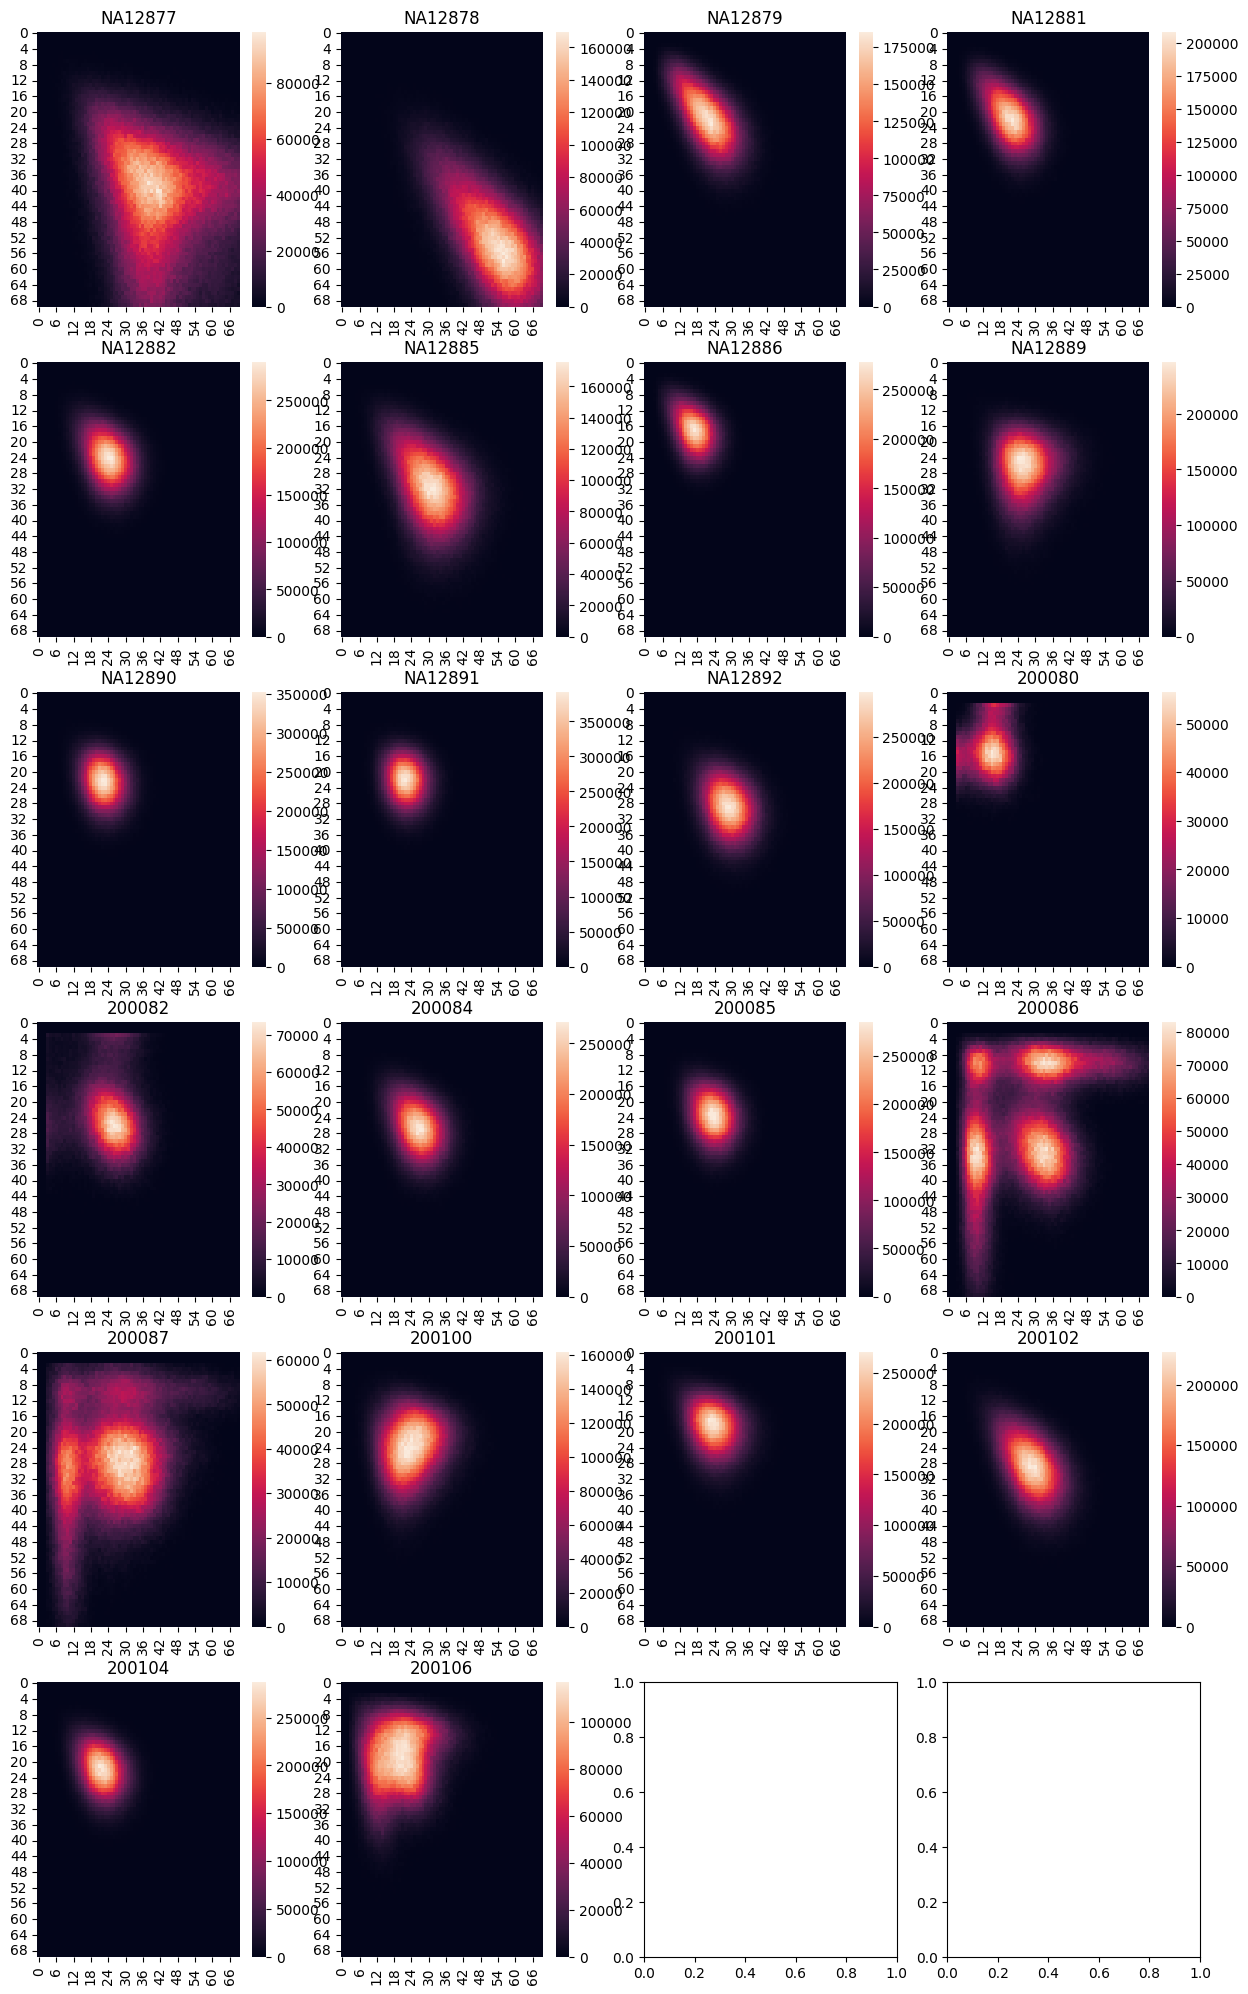

In [90]:
fig, axs = plt.subplots(6, 4, figsize=(15, 25));

for sample_id, ax in zip(ceph_sample_ids, axs.ravel()):
    sub = coverage_hist.filter(pl.col("sample_id") == sample_id)
    A = np.zeros((200, 200))
    A[
        sub["hap1_certainty_0.95_coverage"], 
        sub["hap2_certainty_0.95_coverage"],
    ] = sub["len"]
    sns.heatmap(A[:70,:70], ax=ax);
    ax.set_title(sample_id)


    

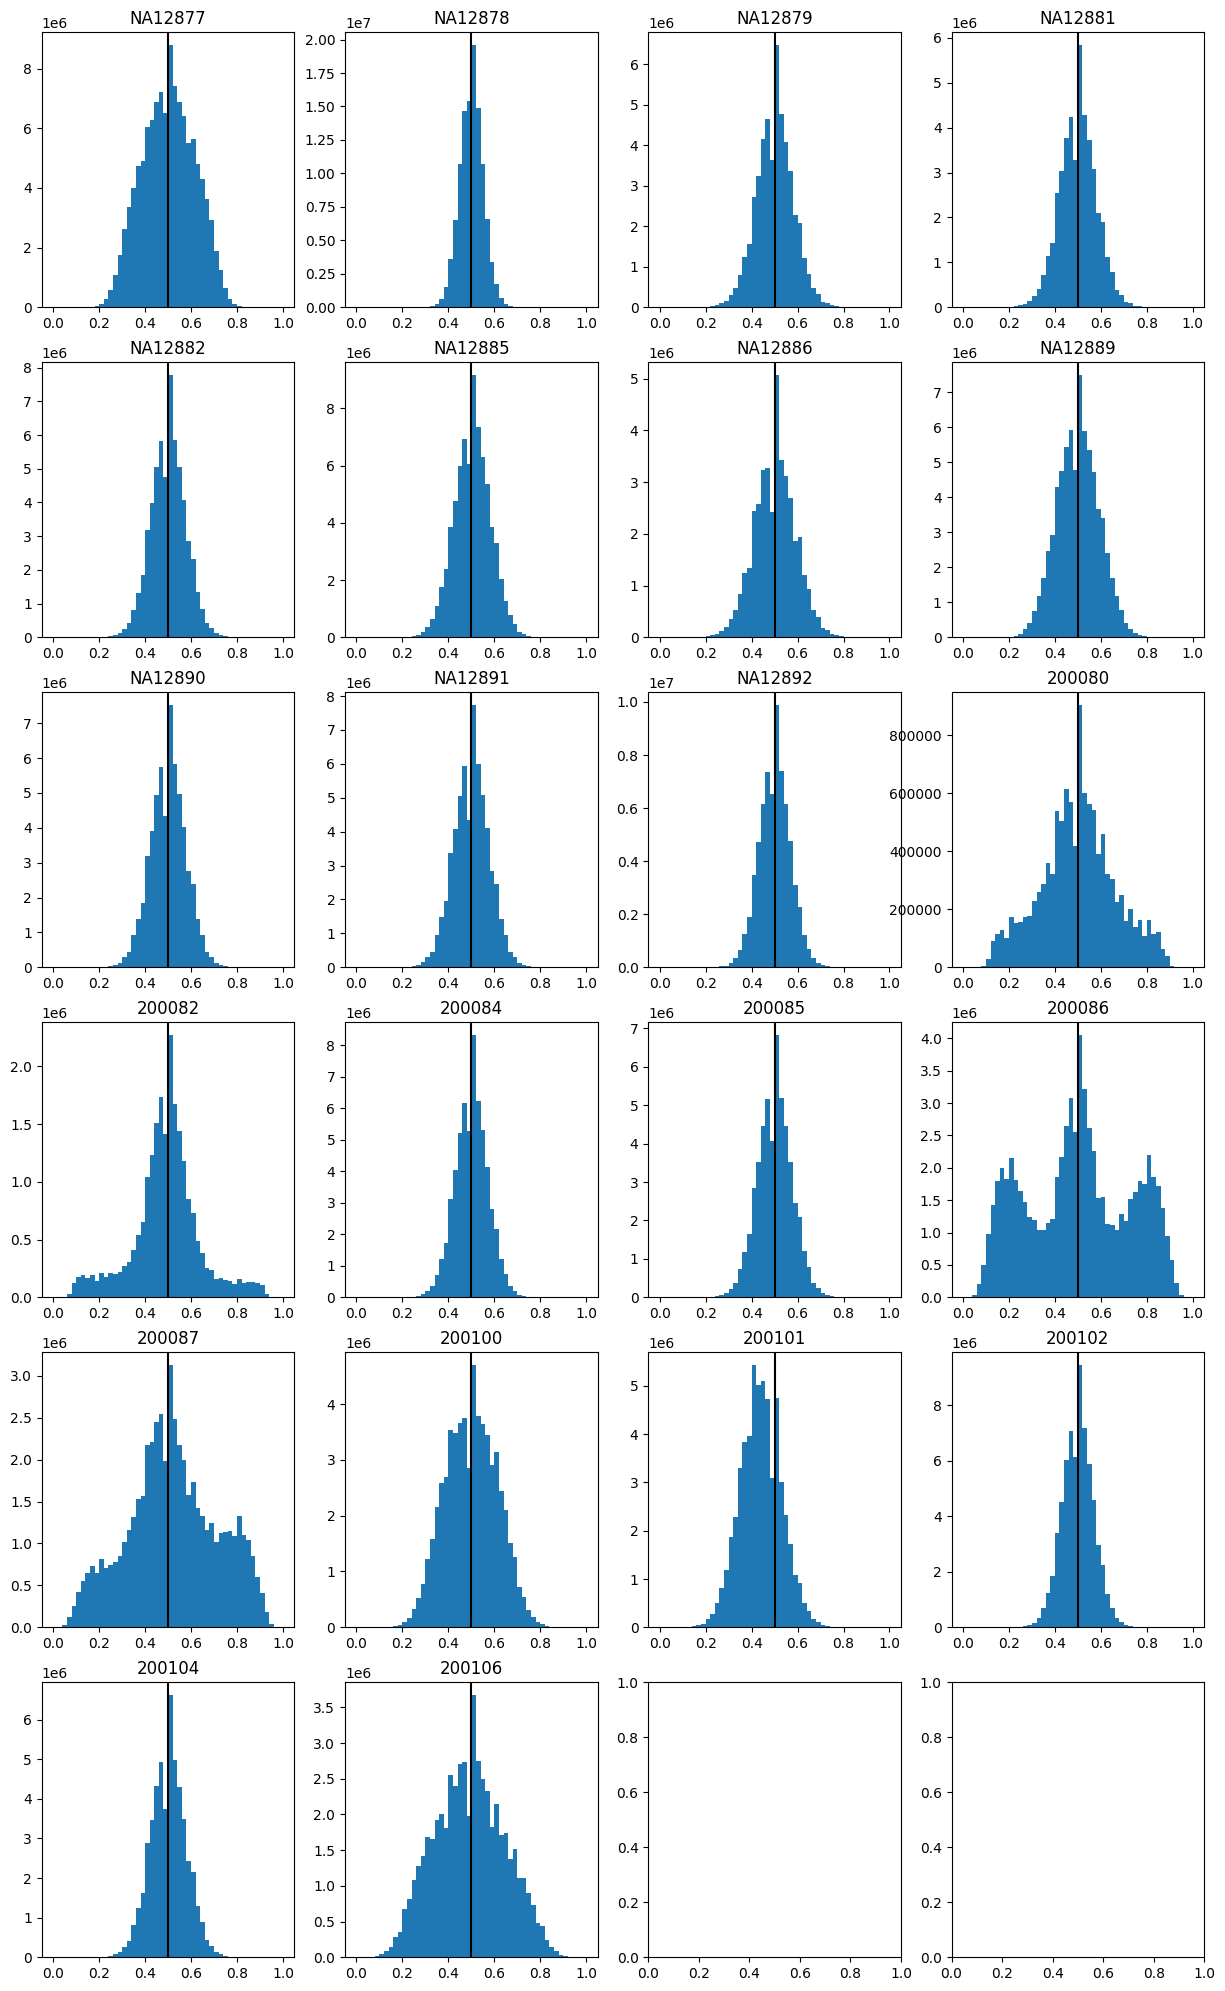

In [91]:
fig, axs = plt.subplots(6, 4, figsize=(15, 25));

for sample_id, ax in zip(ceph_sample_ids, axs.ravel()):
    sub = coverage_hist.filter(pl.col("sample_id") == sample_id)
    A = np.zeros((200, 200))
    A[
        sub["hap1_certainty_0.95_coverage"], 
        sub["hap2_certainty_0.95_coverage"],
    ] = sub["len"]
    x = []
    w = []
    for i in range(200): 
        for j in range(200):
            if i == 0 and j == 0:
                continue
            x.append((i/(i+j)))
            w.append(A[i,j])

    ax.hist(
        x=x, weights=w, bins=50,
    );
    ax.axvline(0.5, color="black");
    ax.set_title(sample_id)


    

In [94]:
%%time
hist_unassigned = (
    ann_snps_df
    .filter((pl.col("hap1_total_coverage") == pl.col("hap2_total_coverage")))
    .with_columns(
         unassigned_reads = (pl.col("hap1_total_coverage") - pl.col("hap1_certainty_0.95_coverage") - pl.col("hap2_certainty_0.95_coverage"))
    )
    .group_by("sample_id", "unassigned_reads")
    .len()
    .collect(streaming=True)
)

CPU times: user 12min 52s, sys: 2min 7s, total: 15min
Wall time: 6min 18s


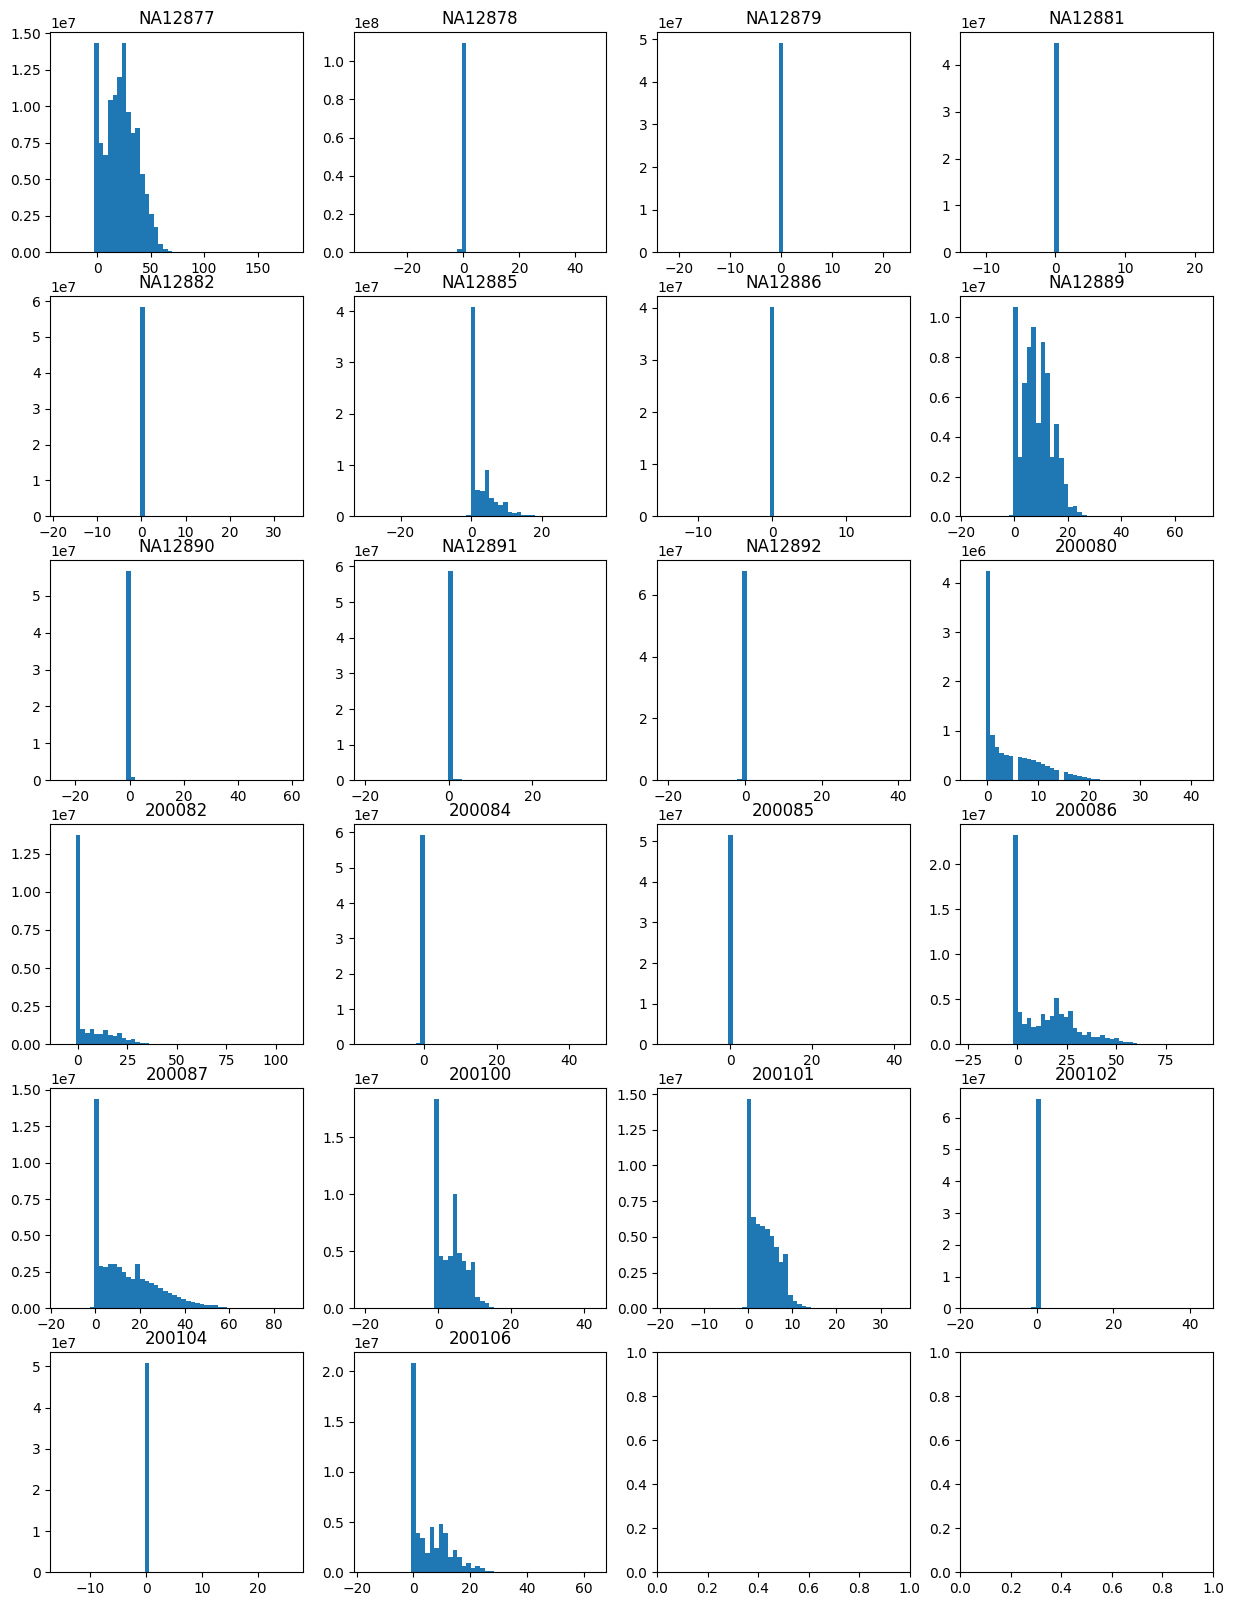

In [97]:
fig, axs = plt.subplots(6, 4, figsize=(15, 20));

for sample_id, ax in zip(ceph_sample_ids, axs.ravel()):
    sub = hist_unassigned.filter(pl.col("sample_id") == sample_id)
    
    x = []
    w = []
    for n, L in zip(sub["unassigned_reads"], sub["len"]):
        x.append(n)
        w.append(L)
   
    ax.hist(
        x=x, weights=w, bins=50,
    );
#    ax.axvline(0.5, color="black");
    ax.set_title(sample_id)


    